# 第三章 检索陷阱


## 目录
- [ 3.1 - 可视化技巧](#31)
- [ 3.2 - 相似性和干扰项](#32)
- [ 3.3 - 总结](#33)

在对文档进行简单的向量检索时，我们可能会遇到一些问题或陷阱：
- **干扰项**：简单的向量检索可能会返回和查询主题相似的文本，但不包含答案，此时这些检索结果反而会对LLM的回复形成干扰；
- **无关结果**：如果用一个和文档主题毫不相关的查询去检索文档，嵌入模型仍然会返回检索结果，此时LLM可能会被检索结果误导，导致回复结果“牛头不对马嘴”。

此时，简单的向量检索就会失效，无法提供准确有效的检索结果。

接下来我们通过可视化方法来更好地观察和解释为何简单向量检索有时会失效。

## 3.1 可视化技巧

首先，我们来导入需要用到的库和数据：

In [1]:
import os
import chromadb.utils.embedding_functions as embedding_functions
from helper_utils import load_chroma, word_wrap
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

## 如果报错：SSLError:(MaxRetryEror("SOCKSHTTPSomectionpool(host='huggingface.co', port-443)，注意挂上梯子并添加以下代码：
os.environ['HTTPS_PROXY'] = 'http://127.0.0.1:7890' # 7890改为自己的梯子端口
os.environ["HTTP_PROXY"]  = 'http://127.0.0.1:7890'

# 读取OpenAI的api key
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) 
openai_api_key = os.environ['OPENAI_API_KEY']

# chromadb支持的嵌入函数有许多种，这里介绍常用的几种：
# 参考资料：https://docs.trychroma.com/embeddings
# 方式1：默认嵌入函数，需要下载模型，本地计算。英文文本表现不错，中文文本表现一般
# embedding_function = SentenceTransformerEmbeddingFunction()

# 方式2：OpenAI的嵌入函数，直接调用OpenAI的接口，无需下载模型，推荐
embedding_function = embedding_functions.OpenAIEmbeddingFunction(
                api_key=openai_api_key,
                model_name="text-embedding-ada-002"
            )

# 方式3：HuggingFace的嵌入函数，需要下载模型，本地计算，对网络要求高
# embedding_function = embedding_functions.HuggingFaceEmbeddingFunction(
#     api_key="hf_",  # 填入你的 huggingface Access Token
#     model_name="jinaai/jina-embeddings-v2-base-zh"  # 指定模型
# )
## 中文备选模型
# jinaai/jina-embeddings-v2-base-zh
# GanymedeNil/text2vec-large-chinese
# BAAI/bge-large-zh-v1.5
# BAAI/bge-small-zh-v1.5


# 初始化chroma，英文文档
# chroma_collection = load_chroma(filename='./data/microsoft_annual_report_2022.pdf', \
#                                 collection_name='microsoft_annual_report_2022', \
#                                 embedding_function=embedding_function,
#                                 langcode='en')

# 初始化chroma，中文文档
chroma_collection = load_chroma(filename='./data/2024年北京市政府工作报告.pdf', \
                                collection_name='beijing_annual_report_2024', \
                                embedding_function=embedding_function,
                                langcode='zh')  # 注意中文文档将langcode改为'zh'
chroma_collection.count()

d:\Anaconda\envs\chroma\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\Anaconda\envs\chroma\lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


1028

接下来我们将用UMAP对嵌入（embedding）矩阵进行可视化，以更好地观察嵌入矩阵元素之间的关系。

UMAP（Uniform Manifold Approximation and Projection）是一种用于降维和数据可视化的算法，类似于 PCA、t-SNE（t-distributed Stochastic Neighbor Embedding）等降维方法，相比 t-SNE 有一些改进，使其在某些情况下更加高效且能够保留数据的全局结构。

安装方式：`pip install umap-learn`。注意是安装`umap-learn`而不是`umap`。

In [2]:
import umap
import numpy as np
from tqdm import tqdm

# 获取整个数据集的嵌入
embeddings     = chroma_collection.get(include=['embeddings'])['embeddings']
# 定义UMAP模型
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)

d:\Anaconda\envs\chroma\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [3]:
def project_embeddings(embeddings, umap_transform):
    """
    用 UMAP 将高维嵌入向量投影到二维向量空间。
    
    Args:
        embeddings (list): 高维嵌入向量。
        umap_transform (umap.UMAP): UMAP模型。

    Returns:
        umap_embeddings (np.ndarray): 二维嵌入向量矩阵。
    """
    
    umap_embeddings = np.empty((len(embeddings),2))
    # 为保证结果可复现，逐个进行umap转换
    for i, embedding in enumerate(tqdm(embeddings)): 
        umap_embeddings[i] = umap_transform.transform([embedding])

    return umap_embeddings   

In [4]:
len(embeddings), len(embeddings[0])

(1028, 1536)

可以看到`embeddings`矩阵的维度高达1536，是一个典型的高维空间，非常复杂，难以观察。

因此我们用`UMAP`方法将其投影到二维平面，方便可视化。

In [5]:
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)
print(f'Before UMAP: {np.array(embeddings).shape}')
print(f'After UMAP: {projected_dataset_embeddings.shape}')

100%|██████████| 1028/1028 [13:53<00:00,  1.23it/s]

Before UMAP: (1028, 1536)
After UMAP: (1028, 2)


投影到二维平面后，我们就可以通过散点图来观察不同点之间的关系了。

(-0.8728130966424943, 5.976743510365486, 3.350202488899231, 11.059748244285583)

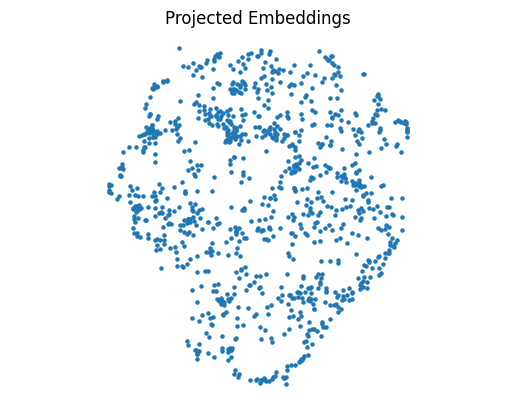

In [6]:
# 绘制散点图
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Projected Embeddings')
plt.axis('off')

一般来说，离得越近的两个点，它们的语义相似度越高，反之越低。

## 3.2 相似性和干扰项

这一节我们通过几个简单的例子来探究简单向量失效的情况。

首先，我们来问问北京的地区生产总值是多少。

In [17]:
query = "地区生产总值是多少？"

# 输入query，返回 n_results 个最相关的查询结果，results 是一个字典，包含了查询结果的文档和嵌入矩阵（方便后续可视化）
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

# 检索结果
retrieved_documents = results['documents'][0]

# 查看检索结果
for document in results['documents'][0]:
    print(word_wrap(document))
    print('')

全市地区生产总
值增长5.2%、约4.4万亿元

数字经济增加值占地区生产总值比重达42.9%

人均地区生产总值、全
员劳动生产率、万元地区生产总值能耗水耗等多项指标保持全国省级地区最优水平

提出今年全市经济社
会发展的主要预期目标是：地区生产总值增长5%左右

着力打造一批乡村产业强镇、优势特色产业集群



可以看到其中一个检索结果就是我们想要的答案，但其他结果并不是我们想要的。

接下来我们用UMAP将查询、检索结果、原始数据都投影到二维平面，并绘制散点图。

In [18]:
query_embedding      = embedding_function([query])[0]  # 查询的嵌入
retrieved_embeddings = results['embeddings'][0]   # 检索的嵌入

# UMAP降维（投影到二维平面）
projected_query_embedding      = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


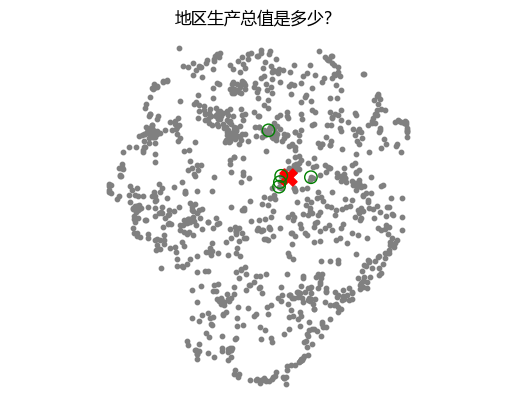

In [19]:
def plot(query, projected_dataset_embeddings, projected_query_embedding, projected_retrieved_embeddings):
    """
    绘制投影后的数据集、查询、检索结果的散点图.
    
    Args:
        query (str): 查询文本。
        projected_dataset_embeddings (np.ndarray): 整个数据集的二维嵌入向量。
        projected_query_embedding (np.ndarray): 查询的二维嵌入向量。
        projected_retrieved_embeddings (np.ndarray): 检索的二维嵌入向量。
    
    Returns:
        None

    """
    plt.figure()
    plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 设置全局字体为微软雅黑，显示中文
    plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray') # 整个数据集的散点图
    plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r') # 查询的散点图
    plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=80, facecolors='none', edgecolors='g') # 检索的散点图

    plt.gca().set_aspect('equal', 'datalim')
    plt.title(f'{query}')
    plt.axis('off')
    plt.show()

plot(query, projected_dataset_embeddings, projected_query_embedding, projected_retrieved_embeddings)

上图中，红色的“×”即为我们的查询（query），绿色圆圈圈住的点为检索结果。

注意：这里我们将高维空间压缩到了二维空间，这个可视化结果并不总是完美的。

可以看到一些检索结果都围绕在查询四周，但也有一些点离得较远。

这些离得远的点就是问题所在，它没有答到点子上。

这是因为**我们问的问题很泛，没有提供足够的背景信息，嵌入模型很难理解我们的意图，难以去完成我们内心期待的特定任务**。

我们换一个问题试试：一般公共预算收入是多少？

In [10]:
query   = "一般公共预算收入是多少？"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

# 检索结果
retrieved_documents = results['documents'][0]

# 查看检索结果
for document in results['documents'][0]:
    print(word_wrap(document))
    print('')

一般公共预算收入增长5%

一般公共预算收入增长8.2%、突破6000亿元

压减一般性支出和非紧急非刚性支出23.9亿元

“三公”经费减少5%；深化全成本
预算绩效管理改革

统筹用好政府投资基金



可以看到前2个结果与问题较为相关，后面的3个结果的相关性逐渐减弱。

接下来进行可视化。

100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


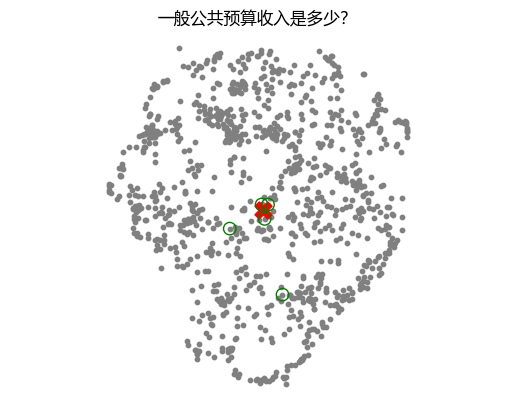

In [11]:
query_embedding      = embedding_function([query])[0]  # 查询的嵌入
retrieved_embeddings = results['embeddings'][0]   # 检索的嵌入

# UMAP降维（投影到二维平面）
projected_query_embedding      = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

# 绘制散点图
plot(query, projected_dataset_embeddings, projected_query_embedding, projected_retrieved_embeddings)

可以看到一些检索结果和我们的查询离得非常近，但也有一些结果离得非常远。

我们再来换一个问题试试。

In [12]:
query   = "城镇新增就业人数多少？"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

# 检索结果
retrieved_documents = results['documents'][0]

# 查看检索结果
for document in results['documents'][0]:
    print(word_wrap(document))
    print('')

城镇新增就业28.1万人

实现城镇新增就业不
少于26万人

城镇调查失业
率4.4%

城镇调
查失业率控制在5%以内

持续增加城乡居民收入



从检索结果来看，第一个检索结果答到了城镇新增就业人数的具体数字，但后面的几个结果存在不少**干扰项**。

干扰项是指和查询主题相似但不包含答案的文本，**如果将这些信息传递给大型语言模型来完成RAG任务，模型往往会被这些信息分散注意力，导致输出次优的结果**。

干扰项导致的模型不良行为对于用户和开发者来说都很难诊断和调试。

因此，让检索系统更加健壮，返回相关结果而不返回干扰项对于模型来说非常重要。

接下来我们将结果进行可视化。

100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


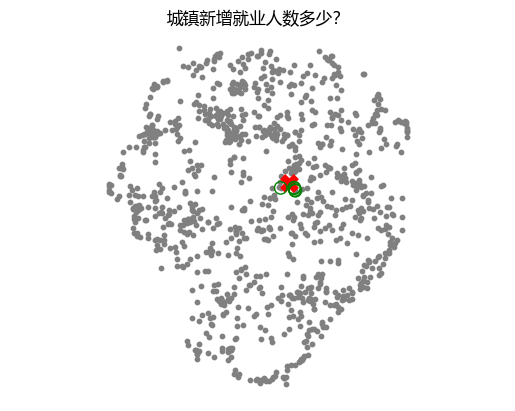

In [13]:
query_embedding      = embedding_function([query])[0]  # 查询的嵌入
retrieved_embeddings = results['embeddings'][0]   # 检索的嵌入

# UMAP降维（投影到二维平面）
projected_query_embedding      = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

# 绘制散点图
plot(query, projected_dataset_embeddings, projected_query_embedding, projected_retrieved_embeddings)

最后我们来尝试换一个与文档无关的话题：乔丹干了啥？

In [14]:
query = "迈克尔·乔丹最近做了什么？"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

# 检索结果
retrieved_documents = results['documents'][0]

# 查看检索结果
for document in results['documents'][0]:
    print(word_wrap(document))
    print('')

过去一年

过去一年

主要做了以下工作

做好新时代北京宗教工作

唱好京津“双城记”



显而易见，乔丹和北京市政府的年度报告没有任何关联，检索结果里也确实没有提到他。

但是，如果我们将检索结果用作RAG任务的一部分，LLM的回答将完全基于这些**无关结果**得到，这就容易出现牛头不对马嘴的情况。

我们再来看一下投影结果：

100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


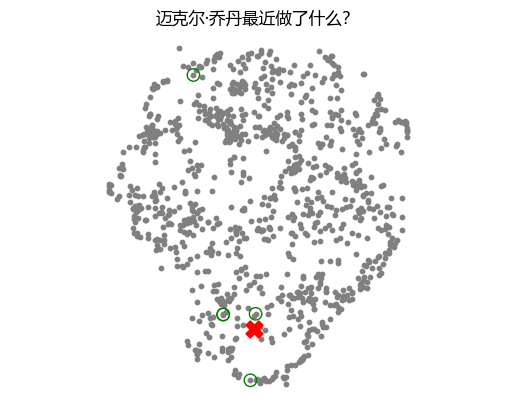

In [15]:
query_embedding      = embedding_function([query])[0]  # 查询的嵌入
retrieved_embeddings = results['embeddings'][0]   # 检索的嵌入

# UMAP降维（投影到二维平面）
projected_query_embedding      = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

# 绘制散点图
plot(query, projected_dataset_embeddings, projected_query_embedding, projected_retrieved_embeddings)

可以看到关于迈克尔·乔丹的结果到处都是，因为查询与我们数据集中的任何数据都毫无关联。

因为这是一种几何类型的数据，想象一下所有的数据是一个位于高维空间中的点云。

**落在点云内部的查询可能会找到最近邻，它们在点云内部密集而紧密地靠在一起，但是落在点云外部的查询可能会找到来自该点云许多不同部分的最近邻，因此它们更加分散。**

而乔丹与我们的文档主题毫不相关，因此这个查询是落在点云外部的查询，故它的查询结果分散在点云四周。

接下来你也可以尝试，换一个查询并可视化一下检索结果，来更好地理解简单向量检索的运行机制和缺点。

<a name='33'></a>
## 3.3 总结

在这个实验中，我们学到了：

- 如何用`UMAP`将高维Embedding向量投影到二维平面并进行可视化；
- **简单的向量检索可能会返回一些无关答案造成干扰**。

在下一个实验中，我们将向你展示通过使用一种称为查询扩展的技术来改善LLMs查询质量的技巧。
